In [2]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
TIMELINE_F = '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Extracted_Per_Event_Interictal/all_time_data_01042023_212306.csv'
SEEG_FOLDER = '/mnt/ernie_main/000_Data/SEEG/SEEG_Entire_EMU_Downloads/data/'

In [3]:
label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))
label_df['bipole'] = label_df.bipole.apply(format_bipole)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ghassan/Ephys/Data/all_pats_bipole_soz_labels.csv'

In [3]:
seeg_timeline_df = pd.read_csv(TIMELINE_F, delimiter="\t")
seeg_timeline_df.head(5)

,Type,Pat ID,Event Number (Matches EMU Final Report),Date (MM:DD:YYYY),Onset String (HH:MM:SS),Offset String (HH:MM:SS),Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown),FileIndex,onset_datetime,offset_datetime,onset_datetime_buffer,offset_datetime_buffer,FileName
0,File,Epat02,File1,09:14:2017,13:05:11,17:05:11,NaN,0,2017-09-14 13:05:11,2017-09-14 17:05:11,2017-09-14 13:06:11,2017-09-14 17:04:11,Epat02_09142017_13051100.EDF
1,File,Epat02,File2,09:14:2017,17:05:22,21:05:22,NaN,1,2017-09-14 17:05:22,2017-09-14 21:05:22,2017-09-14 17:06:22,2017-09-14 21:04:22,Epat02_09142017_17052200.EDF
2,File,Epat02,File3,09:14:2017,21:05:34,01:05:34,NaN,2,2017-09-14 21:05:34,2017-09-15 01:05:34,2017-09-14 21:06:34,2017-09-15 01:04:34,Epat02_09142017_21053400.EDF
3,File,Epat02,File4,09:15:2017,01:05:45,05:05:45,NaN,3,2017-09-15 01:05:45,2017-09-15 05:05:45,2017-09-15 01:06:45,2017-09-15 05:04:45,Epat02_09152017_01054500.EDF
4,File,Epat02,File5,09:15:2017,05:05:56,09:05:56,NaN,4,2017-09-15 05:05:56,2017-09-15 09:05:56,2017-09-15 05:06:56,2017-09-15 09:04:56,Epat02_09152017_05055600.EDF


# Calculating Connectivity Between Channels

It seems my task is much easier than I previously thought. There are designated recordings for my 4 periods of interested already cleaned and labelled by Derek and Graham. Bless.

Goal for this section's exploration: calculate ISH across 4 periods for 1 patient.
1. Find 4 recordings for patient
1. Calc Connectivity (PDC) for each recording
1. Im show some of those recordings
1. calculate inward-outward strengh for 4 periods - ISH
1. BONUS: Redo 1-4 with cross spectral coherence connectivity from the French

## Using Precomputed PDC Peri-Ictally

In [5]:
data_dir = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/'
folders = glob.glob(os.path.join(data_dir, "*pat*"))
sub_ids = [os.path.basename(f) for f in folders]

In [5]:
tst_folders = folders[0:2]
tst_subj = sub_ids[0:2]

In [39]:
tst_folders
#Shoudl have Spat45
## Spat32
# Spat29
# Spat24
# Spat23
# Epat15

['/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat02',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat03',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat04',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat06',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat08',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas_fias/Epat09',
 '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Connectivity/seizure_structs_pre10min_ictal_post10min/5sDur_1sStride_imcoh_fas

In [80]:
# missing_subj_ids = np.array(['Spat32', 'Spat29','Spat24','Spat23','Epat15'])
# missing_folders = [
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat32/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat29/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat24/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat23/',
#     '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat15/'
# ]

In [19]:
tst_df = agg_subjects(folders[0:2], sub_ids[0:2], label_df,filter_dist=20)

In [83]:
set(missing_df.subj)

{'Epat15', 'Spat23', 'Spat24', 'Spat29', 'Spat32'}

In [84]:

full_peri_ictal_df = agg_subjects(folders, sub_ids, label_df,filter_dist=20)

Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat26/Epat26_19_FAS_imcoh.mat


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat27/Epat27_19_FAS_imcoh.mat


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:137: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat45/Spat45_13_FAS_imcoh.mat
Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat45/Spat45_15_FAS_imcoh.mat
Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat46/Spat46_5_FIAS_imcoh.mat
Problem Loading /mnt/ernie_main/Ghassan/ephys/data/connectivity/Spat50/Spat50_69_FIAS_imcoh.mat


In [85]:
full_peri_ictal_df

,subj,period,region,net_pdc,freq_band,conn_file
0,Epat02,inter,soz,0.414580,delta,Epat02_10_FIAS_imcoh.mat
1,Epat02,inter,pz,0.009915,delta,Epat02_10_FIAS_imcoh.mat
2,Epat02,inter,nz,-0.018264,delta,Epat02_10_FIAS_imcoh.mat
3,Epat02,inter,soz,0.442180,theta,Epat02_10_FIAS_imcoh.mat
4,Epat02,inter,pz,0.012681,theta,Epat02_10_FIAS_imcoh.mat
...,...,...,...,...,...,...
67,Spat52,post,pz,-0.298211,gamma_l,Spat52_7_FIAS_imcoh.mat
68,Spat52,post,nz,0.049149,gamma_l,Spat52_7_FIAS_imcoh.mat
69,Spat52,post,soz,-0.391738,gamma_H,Spat52_7_FIAS_imcoh.mat
70,Spat52,post,pz,-0.287915,gamma_H,Spat52_7_FIAS_imcoh.mat


In [4]:
full_peri_ictal_df.to_csv("../data/peri_ictal_conn_excl_dist.csv",index=False)

NameError: name 'full_peri_ictal_df' is not defined

In [5]:
full_df = pd.read_csv("../data/peri_ictal_conn_excl_dist.csv")

## Analyzing Peri Ictal Dynamics

In [6]:
peri_ictal_df = full_df[['subj','period','region','net_pdc','freq_band']]

In [8]:
peri_stats_df = peri_ictal_df.groupby(['subj', 'period', 'freq_band','region']).mean().reset_index()
peri_stats_df

,subj,period,freq_band,region,net_pdc
0,Epat02,ictal,alpha,nz,-0.035798
1,Epat02,ictal,alpha,pz,-0.105309
2,Epat02,ictal,alpha,soz,1.685816
3,Epat02,ictal,beta,nz,-0.050432
4,Epat02,ictal,beta,pz,-0.032375
...,...,...,...,...,...
4315,pat33,pre,gamma_l,pz,NaN
4316,pat33,pre,gamma_l,soz,0.071440
4317,pat33,pre,theta,nz,-0.003189
4318,pat33,pre,theta,pz,NaN


In [9]:
peri_alpha_df = peri_stats_df[peri_stats_df.freq_band == 'alpha']

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

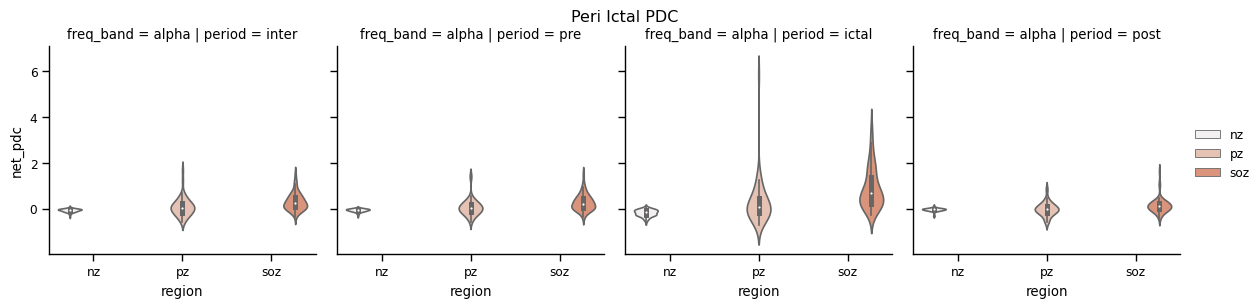

In [19]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(peri_alpha_df,col='period', row='freq_band',col_order=['inter','pre','ictal','post']) 
        grid.map_dataframe(sns.violinplot, y='net_pdc',x='region', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PDC",y=1.01)
        plt.savefig("../viz/peri_alpha_pdc.pdf",transparent=True)


## ISH OG Cohort

In [27]:
og_ISH = load_mat('/mnt/ernie_main/PCA_project/data/original_81_structs/PDC_pats.mat')

ish_subj_df = pd.read_csv('../data/ish_subid.csv',header=None)
ish_subj_df.columns = ['og_id']

In [28]:
ish_subj_df['subj_id'] = ish_subj_df.og_id.apply(lambda x : x.split("_")[0])
common_ids = set(ish_subj_df.subj_id).intersection(sub_ids)
len(common_ids) == len(sub_ids) 
#Sanity check to make sure that I have all the
#peri ictal cohort in the ISH cohort. Should be True

True

array(['SOZ', 'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'PZ', 'PZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ', 'SOZ', 'SOZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ', 'SOZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ'], dtype='<U3')

In [226]:

epat_26_f = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat26/Epat26_3_FIAS_imcoh.mat'
epat_26_obj = load_mat(epat_26_f)

pat_df = label_df[label_df.subj == 'Epat26']
regions = get_regions(pat_df, epat_26_obj,'Epat26')

##IF this is true then there is no issue in my designations of SOZ PZ
np.where(regions == epat_26_labels)[0].shape[0] == regions.shape[0]

In [29]:
ish_conn_df = struct_to_pat_df(og_ISH, ish_subj_df.subj_id)

Subj Epat27 has no PZ designation
Subj Epat05 has no PZ designation
Subj Epat11 has no PZ designation


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

Subj Epat22 has no PZ designation
Subj pat33 has no PZ designation
Subj Spat32 has no PZ designation
Subj Spat53 has no PZ designation


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:123: RuntimeWarning: Mean of empty slice
  net_soz = np.nanmean(soz_in) - np.nanmean(soz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connect

Subj Spat27 has no PZ designation
Subj Epat41 has no PZ designation


/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:129: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

In [30]:
ish_conn_df

,subj,period,region,net_pdc,freq_band
0,Epat26,eyes_closed_inter,soz,0.910428,theta
1,Epat26,eyes_closed_inter,pz,-0.142375,theta
2,Epat26,eyes_closed_inter,nz,-0.180864,theta
3,Epat26,eyes_closed_inter,soz,0.907172,alpha
4,Epat26,eyes_closed_inter,pz,0.081661,alpha
...,...,...,...,...,...
10,Epat41,eyes_closed_inter,pz,NaN,gamma_l
11,Epat41,eyes_closed_inter,nz,-0.035532,gamma_l
12,Epat41,eyes_closed_inter,soz,0.275541,gamma_H
13,Epat41,eyes_closed_inter,pz,NaN,gamma_H


In [31]:
peri_subj = set(peri_ictal_df.subj)
ish_subj = set(ish_conn_df.subj)

## Flow Between States

In [3]:
flow_df = map_cohort_to_flow(sub_ids, folders, label_df)
flow_df.to_csv("../data/peri_ictal_flow_full.csv")

NameError: name 'sub_ids' is not defined

In [4]:
flow_df

NameError: name 'flow_df' is not defined

In [5]:
flow_df = pd.read_csv("../data/peri_ictal_flow_full.csv")
flow_df = flow_df[['source','target','value','subj','band','period','seizure']]
flow_df

,source,target,value,subj,band,period,seizure
0,soz,soz,0.102600,Epat02,delta,inter,FIAS
1,soz,pz,0.608197,Epat02,delta,inter,FIAS
2,soz,nz,0.767427,Epat02,delta,inter,FIAS
3,pz,soz,0.675854,Epat02,delta,inter,FIAS
4,pz,pz,6.086276,Epat02,delta,inter,FIAS
...,...,...,...,...,...,...,...
60691,pz,pz,0.111288,Spat52,gamma_H,post,FIAS
60692,pz,nz,3.900411,Spat52,gamma_H,post,FIAS
60693,nz,soz,2.912169,Spat52,gamma_H,post,FIAS
60694,nz,pz,1.070887,Spat52,gamma_H,post,FIAS


In [6]:
pat = 'Epat20'
tst_df = flow_df[flow_df.subj == pat]
i=0
for sz in set(tst_df.seizure):
    sz_df = tst_df[tst_df.seizure == sz]
    for b in BANDS:
        # print(b)
        band_df = sz_df[sz_df.band==b]
        for p in set(band_df.period): 
            total_flow = np.sum(band_df[band_df.period == p].value)
            if abs(100- total_flow > .1):
                print(f"Flow not adding up for {pat}")
                i+=1
i


0

In [7]:
band_df = flow_df[flow_df.band == 'gamma_H']
prev_period = ""
flow_stats_df = []
group_level_df =[]
for period in PERIOD:
    #group periods and fix source target labelling
    period_df = band_df[band_df.period == period]
    if prev_period !='':
        period_df['source'] = period_df.apply(lambda x: x['source'] +'_'+prev_period, axis=1)
    period_df['target'] = period_df.apply(lambda x: x['target'] +'_'+period, axis=1)
    prev_period = period

    #get per period statistics
    #first group within subjects
    group_stats_flow_df = period_df[['source','target','subj','value']].groupby(['source','target','subj']).mean()
    group_stats_flow_df = group_stats_flow_df.reset_index()
    group_level_df.append(group_stats_flow_df)
    # stats across groups now
    summary_df = group_stats_flow_df[['source','target','value']].groupby(['source','target']).mean().reset_index()


    flow_stats_df.append(summary_df)

flow_stats_df = pd.concat(flow_stats_df)
group_level_df = pd.concat(group_level_df)


/tmp/ipykernel_24915/3806023537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['target'] = period_df.apply(lambda x: x['target'] +'_'+period, axis=1)
/tmp/ipykernel_24915/3806023537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['source'] = period_df.apply(lambda x: x['source'] +'_'+prev_period, axis=1)
/tmp/ipykernel_24915/3806023537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [8]:
group_level_df

,source,target,subj,value
0,nz,nz_inter,Epat02,61.643549
1,nz,nz_inter,Epat03,58.767143
2,nz,nz_inter,Epat04,69.977421
3,nz,nz_inter,Epat06,59.521534
4,nz,nz_inter,Epat08,23.667507
...,...,...,...,...
535,soz_ictal,soz_post,Spat50,0.411503
536,soz_ictal,soz_post,Spat51,13.157351
537,soz_ictal,soz_post,Spat52,0.708524
538,soz_ictal,soz_post,pat11,0.000000


In [9]:
from scipy.stats import f_oneway
nz_groups = group_level_df[group_level_df.target.isin(['nz_inter','nz_pre','nz_ictal','nz_post'])]
nzinter = nz_groups[nz_groups.target =='nz_inter'].value
nzpre = nz_groups[nz_groups.target =='nz_pre'].value
nzictal = nz_groups[nz_groups.target =='nz_ictal'].value
nzpost = nz_groups[nz_groups.target =='nz_post'].value
F, p = f_oneway(nzinter, nzpre, nzictal, nzpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 0.634051377950704
p values: 0.593215585556679


In [10]:

pz_groups = group_level_df[group_level_df.target.isin(['pz_inter','pz_pre','pz_ictal','pz_post'])]
pzinter = pz_groups[pz_groups.target =='pz_inter'].value
pzpre = pz_groups[pz_groups.target =='pz_pre'].value
pzictal = pz_groups[pz_groups.target =='pz_ictal'].value
pzpost = pz_groups[pz_groups.target =='pz_post'].value
F, p = f_oneway(pzinter, pzpre, pzictal, pzpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 0.26054736574445403
p values: 0.8538244183720844


In [11]:

soz_groups = group_level_df[group_level_df.target.isin(['soz_inter','soz_pre','soz_ictal','soz_post'])]
sozinter = soz_groups[soz_groups.target =='soz_inter'].value
sozpre = soz_groups[soz_groups.target =='soz_pre'].value
sozictal = soz_groups[soz_groups.target =='soz_ictal'].value
sozpost = soz_groups[soz_groups.target =='soz_post'].value
F, p = f_oneway(sozinter, sozpre, sozictal, sozpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 6.009158792005015
p values: 0.00047985032325588244


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Sankey   [source,target]   (value)
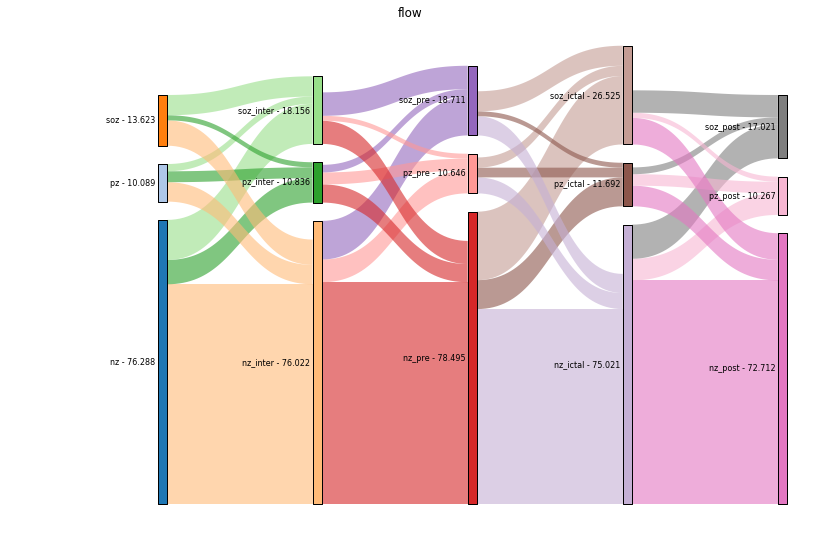

In [28]:
# hv.extension('matplolib')
# sankey = hv.Sankey(flow_stats_df, label="flow")
# sankey.opts(label_position='left', edge_color='target', node_color='index',cmap='tab20')
# # hv.save(sankey, "../viz/soz_flow.pdf", fmt='pdf')

## Plottin Directed Graphs

In [100]:
flow_stats_df['period'] = flow_stats_df.target.apply(lambda x: x.split("_")[1])
flow_df = flow_stats_df
flow_df.source = flow_df.source.apply(lambda x : x.split("_")[0])
flow_df.target = flow_df.target.apply(lambda x : x.split("_")[0])
flow_df

,source,target,value,period
0,nz,nz,58.993035,inter
1,nz,pz,6.527068,inter
2,nz,soz,10.767942,inter
3,pz,nz,5.208995,inter
4,pz,pz,2.932386,inter
5,pz,soz,1.947723,inter
6,soz,nz,6.805295,inter
7,soz,pz,1.376816,inter
8,soz,soz,5.440740,inter
0,nz,nz,59.543089,pre


,source,target,value
0,nz_inter,nz,59.543089
1,nz_inter,pz,6.110856
2,nz_inter,soz,10.368323
3,pz_inter,nz,4.886424
4,pz_inter,pz,3.206139
5,pz_inter,soz,2.042328
6,soz_inter,nz,6.213590
7,soz_inter,pz,1.328871
8,soz_inter,soz,6.300380


In [103]:
period_flow_df

,source,target,value,period
0,nz,nz,58.993035,inter
1,nz,pz,6.527068,inter
2,nz,soz,10.767942,inter
3,pz,nz,5.208995,inter
4,pz,pz,2.932386,inter
5,pz,soz,1.947723,inter
6,soz,nz,6.805295,inter
7,soz,pz,1.376816,inter
8,soz,soz,5.440740,inter


In [118]:
PERIOD

['inter', 'pre', 'ictal', 'post']

[19.664345069982012, 2.1756893398872483, 3.5893140476490895, 1.7363315182483843, 0.9774618563175216, 0.6492409369573793, 2.2684317851045455, 0.45893870483958543, 1.813580074347566]


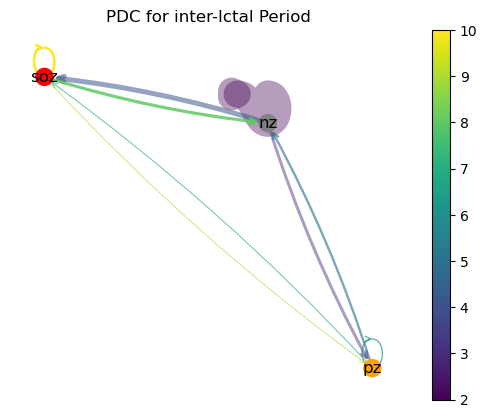

In [136]:
import networkx as nx

seed = 1640


for period in [PERIOD[0]]:
    period_flow_df =  flow_df[flow_df.period==period].drop('period',axis=1)
    edge_list = [(src, tgt, {'weight':val}) for src, tgt, val in period_flow_df.values]
    G, pos = setup_graph(edge_list, seed)
    out_f = f'PDC_{period}_flow.pdf'
    weights = []
    for e in G.edges:
        weights.append(G[e[0]][e[1]][0]['weight']/3)
    print(weights)
    plot_graph(G, pos, weights, out_f)
    plt.title(f'PDC for {period}-Ictal Period')
    break
    



In [111]:
out_f

'post_flow.pdf'

In [24]:
viz_df

,source,target,value
0,nz,nz,58.993035
1,nz,pz,6.527068
2,nz,soz,10.767942
3,pz,nz,5.208995
4,pz,pz,2.932386
5,pz,soz,1.947723
6,soz,nz,6.805295
7,soz,pz,1.376816
8,soz,soz,5.440740


In [81]:
node_labels = [ n for n in G.nodes]
node_labels

['nz', 'pz', 'soz']

In [120]:
#render color plots

# def get_flow_df(full_flow_df, period):
#     viz_df = full_flow_df[full_flow_df.target.isin([f'nz_{period}', f'pz_{period}',f'soz_{period}'])]
#     viz_df.target = viz_df.target.apply(lambda x: x.split("_")[0])
#     return viz_df

def setup_graph(edge_list, seed):

    G = nx.MultiDiGraph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G, seed=seed)
    return G, pos

def plot_graph(G, pos, weights, out_f, cmap = plt.cm.viridis, n_size=150):

    #setup
    node_sizes = [n_size  for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]


    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=['gray','orange','red'])
    nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        arrows=True,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=weights,
        connectionstyle='arc3, rad=0.05'
    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])
    pc = matplotlib.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)

    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(pc, ax=ax)
    plt.savefig(f'../viz/{out_f}')



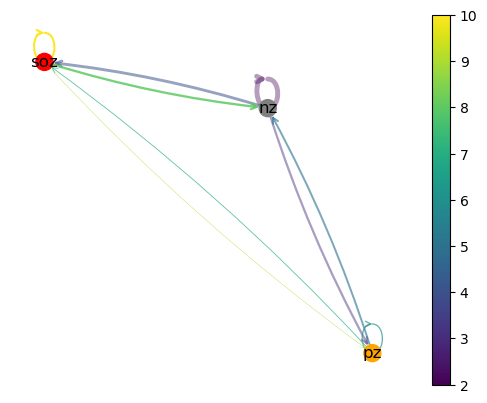

In [85]:
plot_graph(G, pos, node_sizes, 'inter_conn.pdf')